In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE reimplementation

For a 1D GP

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(3)

In [11]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, 1, 1/args["n"]),

    # VAE configuration
    "hidden_dim1": 35,
    "hidden_dim2": 32,
    "latent_dim": 30,
    "vae_var": 0.1,

    # learning
    "num_epochs": 200,
    "learning_rate": 1.0e-3,
    "batch_size": 500,
    "train_num_batches": 40,
    "test_num_batches": 2,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,

    "pretrained_vae": True


})

rng_key, _ = random.split(random.PRNGKey(4))

### Examples of priors to encode

## SVI to learn VAE parameters

Starting, need 20000
Looped: gen 1000/19000 , elapsed: 1.7747125625610352, last batch in 1.7747125625610352
Looped: gen 1000/18000 , elapsed: 3.3807339668273926, last batch in 1.6060214042663574
Looped: gen 1000/17000 , elapsed: 4.70557165145874, last batch in 1.3248376846313477
Looped: gen 1000/16000 , elapsed: 6.144263744354248, last batch in 1.4386920928955078
Looped: gen 1000/15000 , elapsed: 7.571161985397339, last batch in 1.4268982410430908
Looped: gen 1000/14000 , elapsed: 9.365716695785522, last batch in 1.7945547103881836
Looped: gen 1000/13000 , elapsed: 10.738346576690674, last batch in 1.3726298809051514
Looped: gen 1000/12000 , elapsed: 12.125508546829224, last batch in 1.3871619701385498
Looped: gen 1000/11000 , elapsed: 13.971417903900146, last batch in 1.8459093570709229
Looped: gen 1000/10000 , elapsed: 16.10261058807373, last batch in 2.131192684173584
Looped: gen 1000/9000 , elapsed: 17.617644548416138, last batch in 1.5150339603424072
Looped: gen 1000/8000 , elapse

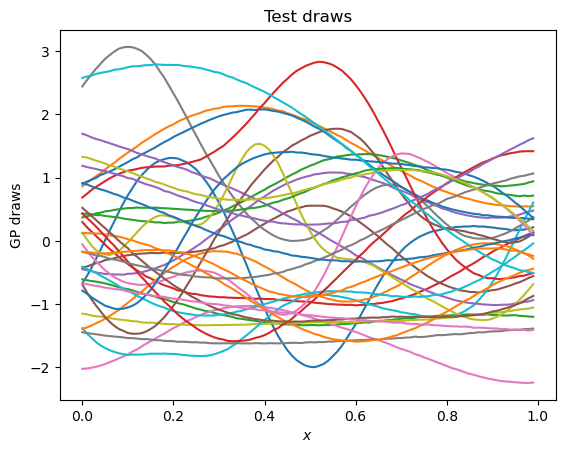

In [6]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP
    from reusable.data import gen_gp_batches
    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    
    train_draws = gen_gp_batches(args["x"], OneDGP, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train)
    test_draws = gen_gp_batches(args["x"], OneDGP, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test)
    
    from plotting.plots import plot_draws

    plot_draws(train_draws[4], args["x"], "Test draws", "GP draws")




In [7]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]  # initialize parameters by passing a template input
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


epoch: 1, test_loss: 0.24186423420906067, train_loss: 0.5551140308380127
epoch: 6, test_loss: 0.22759628295898438, train_loss: 0.5170422792434692
epoch: 11, test_loss: 0.06899696588516235, train_loss: 0.2928819954395294
epoch: 16, test_loss: 0.07118459790945053, train_loss: 0.2922004759311676
epoch: 21, test_loss: 0.07088316977024078, train_loss: 0.29154956340789795
epoch: 26, test_loss: 0.0745287612080574, train_loss: 0.29560530185699463
epoch: 31, test_loss: 0.06935646384954453, train_loss: 0.29094013571739197
epoch: 36, test_loss: 0.06848844885826111, train_loss: 0.2907660901546478
epoch: 41, test_loss: 0.07263457030057907, train_loss: 0.21214453876018524
epoch: 46, test_loss: 0.0709986537694931, train_loss: 0.2076074331998825
epoch: 51, test_loss: 0.07612302154302597, train_loss: 0.21045230329036713
epoch: 56, test_loss: 0.07358287274837494, train_loss: 0.21047964692115784
epoch: 61, test_loss: 0.07114434987306595, train_loss: 0.2079441398382187
epoch: 66, test_loss: 0.070618085563

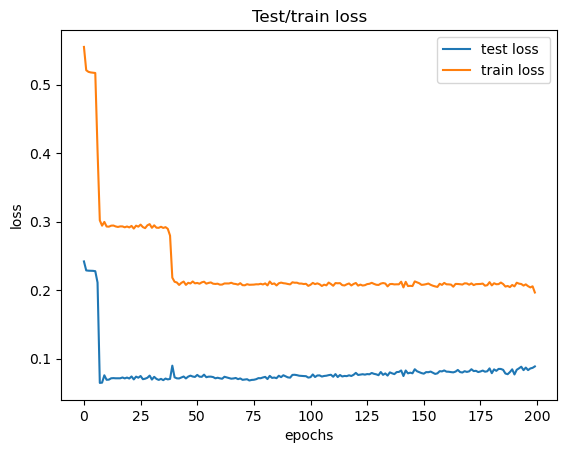

In [8]:
from plotting.plots import plot_training

from reusable.loss import combo_loss, RCL, KLD

if not args["pretrained_vae"]:
    from reusable.train_nn import run_training

    state, metrics_history = run_training(
            combo_loss(RCL, KLD), lambda *_: {}, args["num_epochs"], train_draws, test_draws[0], state
        )


    plot_training(metrics_history["test_loss"], metrics_history["train_loss"], "Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [14]:
from reusable.util import gen_file_name, save_training, load_training_state, get_decoder_params


if not args["pretrained_vae"]:
    save_training("02", gen_file_name("02", args), state, metrics_history )

if args["pretrained_vae"]:
    state = load_training_state("02", gen_file_name("02", args), state)
    args["decoder_params"] = get_decoder_params(state) 
   

## Demonstrations

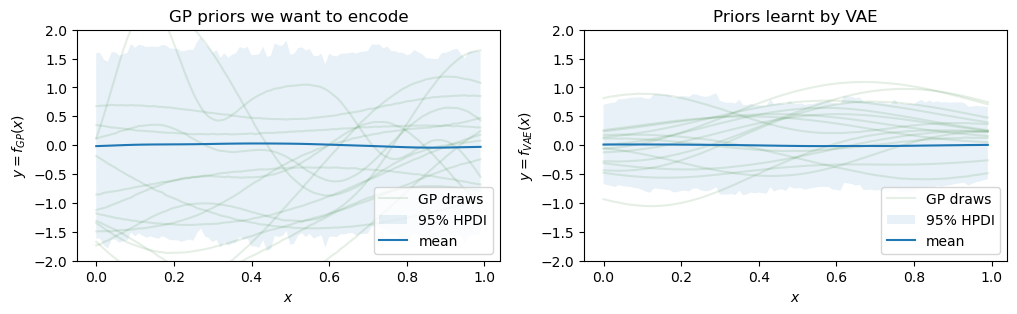

In [15]:
from reusable.vae import vae_sample
from plotting.plots import compare_draws
from reusable.gp import OneDGP
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/01_prior_comp.png")


# Inference

In [16]:
import os


def run_mcmc(rng_key, model_mcmc, y_obs, obs_idx, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


In [18]:
from reusable.mcmc import vae_mcmc

rng_key_ground_truth = random.PRNGKey(
    1
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], noise=True
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T


x_obs_lst = []
y_obs_lst = []
predictions_lst = []

obs_idx_lst = [[22, 50], [16, 33, 57, 96], [8, 24, 45, 61, 77, 84]]



rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

for i in range(len(obs_idx_lst)):
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = ground_truth_y_draw[obs_idx, 0]
    x_obs = args["x"][obs_idx]


    # inference
    mcmc_samples = run_mcmc(rng_key_post, vae_mcmc, y_obs, obs_idx)
    # hidden_dim1, hidden_dim2, latent_dim, out_dim, decoder_params
    predictive = Predictive(vae_mcmc, mcmc_samples)
    predictions = predictive(
        rng_key_pred,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]

    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)





  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 5.563525438308716


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 5.080052137374878


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 5.094897031784058


In [19]:
prior_predictive = Predictive(vae_sample, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior,  hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"])["f"]



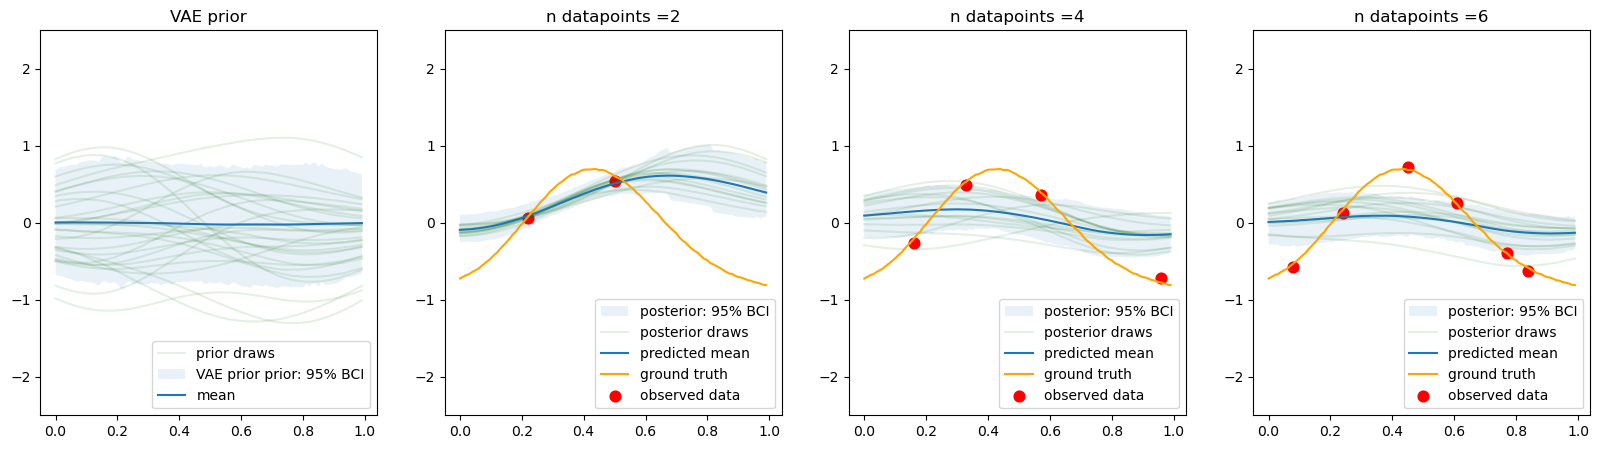

In [20]:
from plotting.plots import compare_inference_steps


compare_inference_steps(args["x"], ground_truth, x_obs_lst, y_obs_lst, prior_predictions, predictions_lst, title="VAE", save_path="gen_plots/02_inference_steps.png")

## Covariance matrices

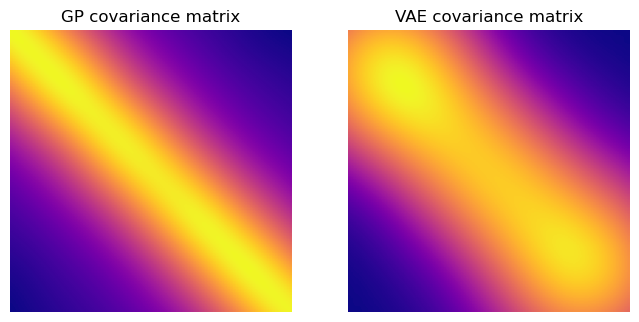

In [21]:
from plotting.plots import plot_cov_mat
import matplotlib.pyplot as plt

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

vae_predictive = Predictive(vae_sample, num_samples=10000)

vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))

plot_cov_mat(gp_draws, "GP covariance matrix", axs[0])
plot_cov_mat(vae_draws, "VAE covariance matrix", axs[1])




0.8091922 148.85278
[[1230.2688 1412.7739 1569.5083 2026.838  2402.6768]]


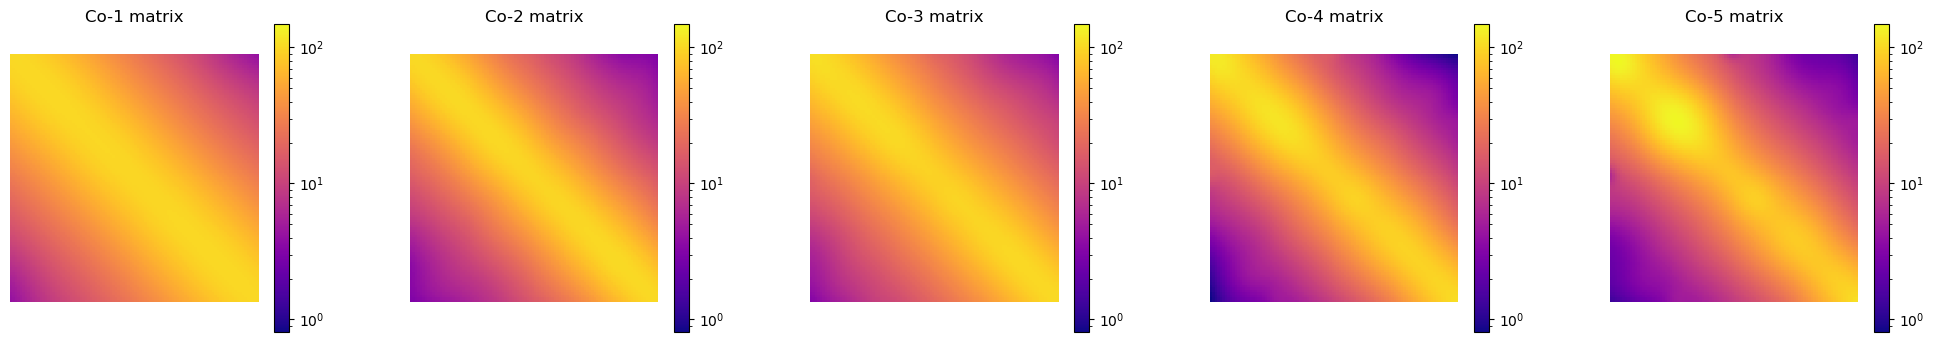

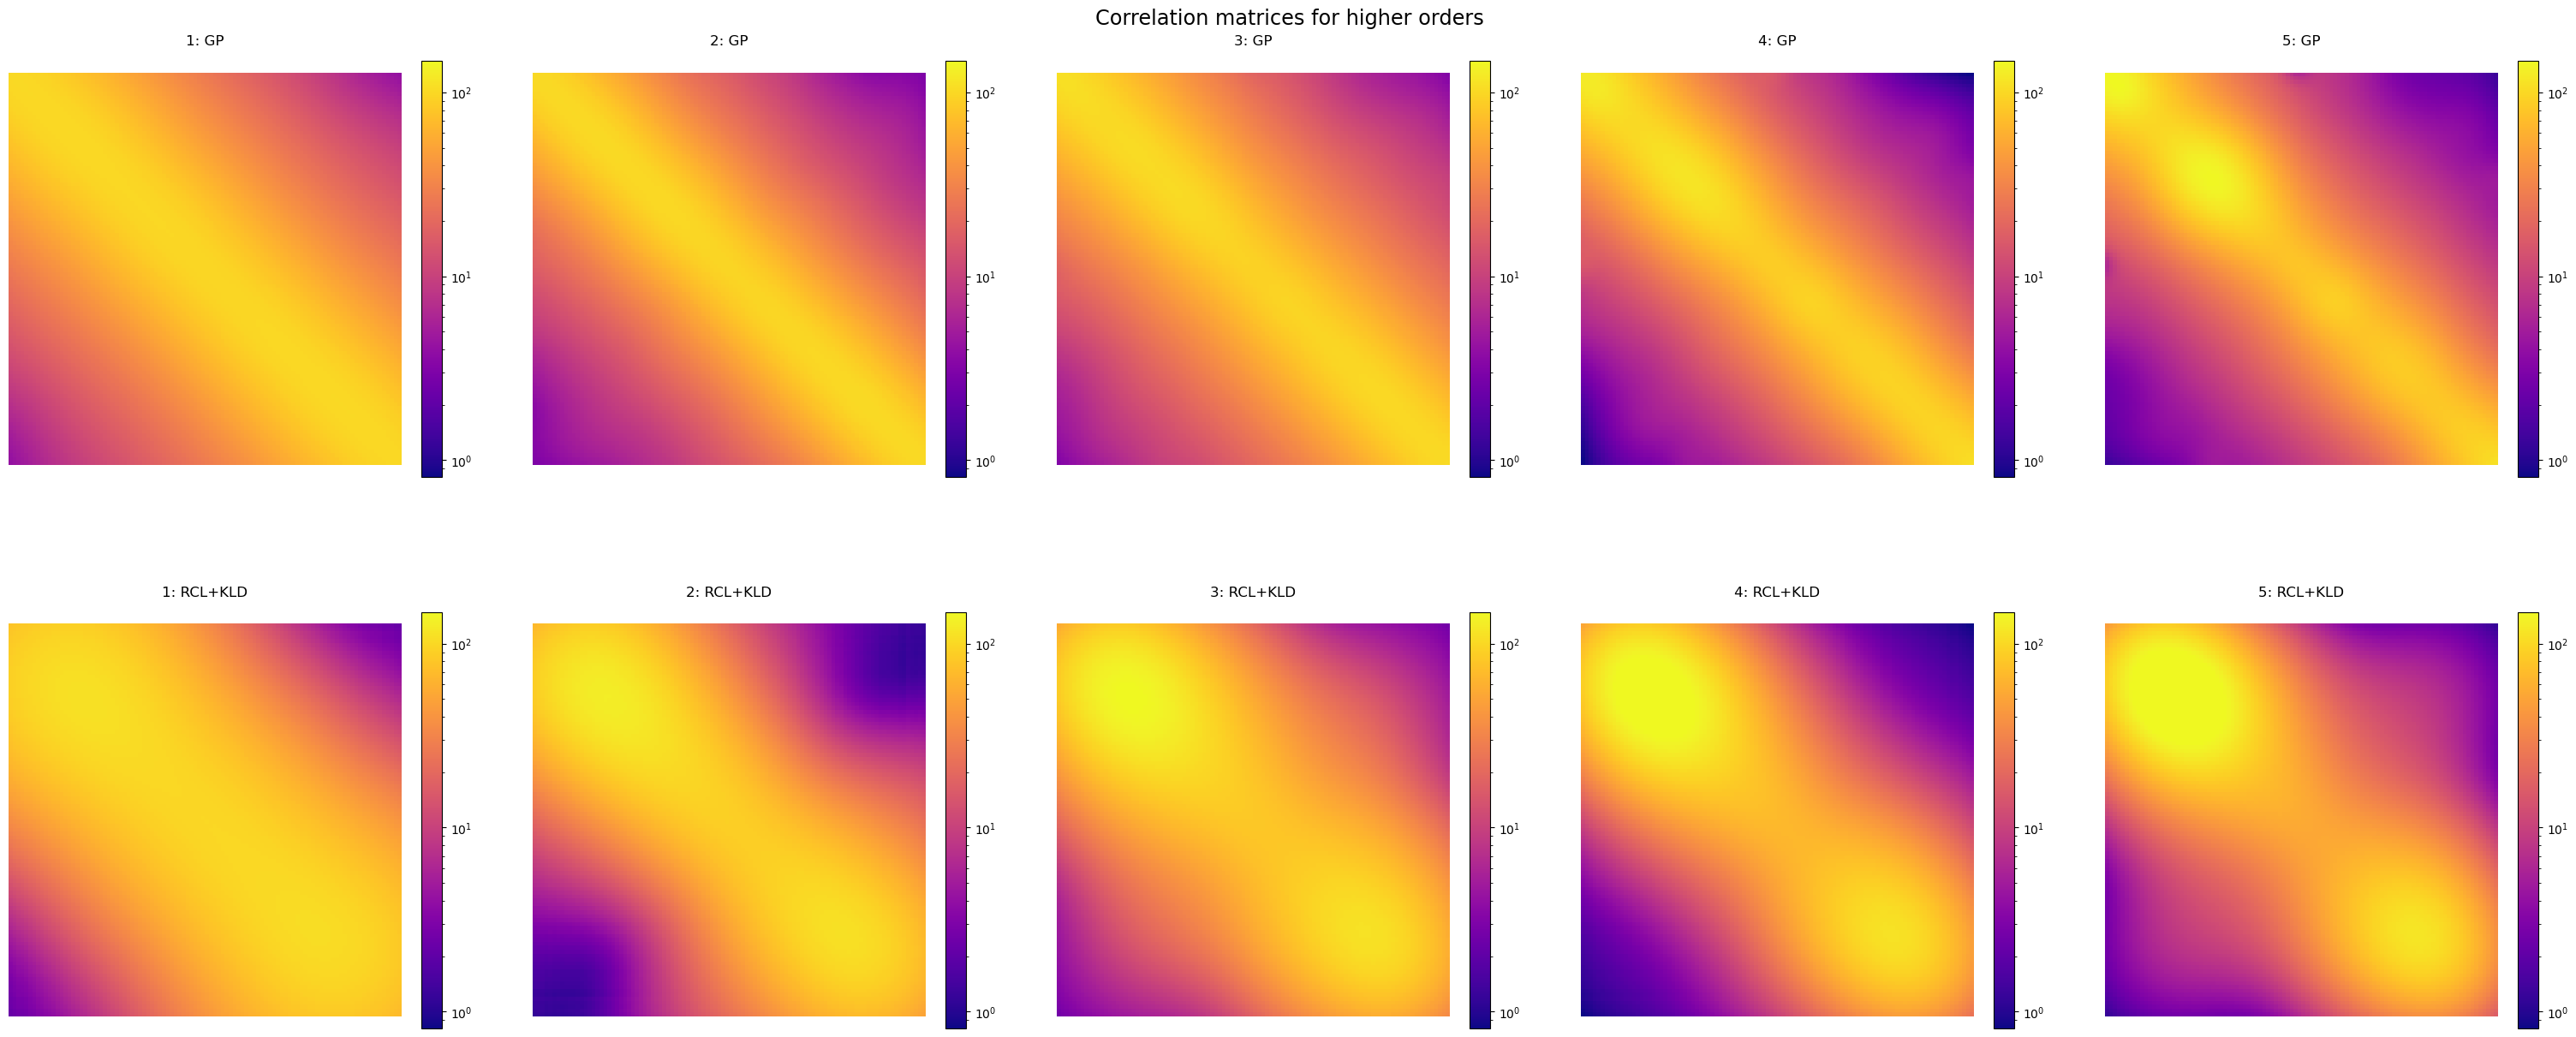

In [22]:
from plotting.plots import plot_matrix
from reusable.moments import alt_correlation_order, covariance

gp_mats = []

matrix_orders = [1,2,3,4,5]

fig = plt.figure(figsize=(4 * len(matrix_orders), 4))
mat_figs = fig.subfigures(nrows=1, ncols=len(matrix_orders))

for  i, order in enumerate(matrix_orders):
    gp_mats.append(alt_correlation_order(gp_draws, order))

vmin = max(0.001, min([jnp.min(m, axis=None) for m in gp_mats]))

vmax =  max([jnp.max(m, axis=None) for m in gp_mats])

print(vmin, vmax)
for i, order in enumerate(matrix_orders):
    plot_matrix(gp_mats[i], f"Co-{order} matrix", vmin=vmin, vmax=vmax, fig=mat_figs[i])


fig = plt.figure(layout='constrained', figsize=(6 * len(matrix_orders), 6+ 6))
subfigs = fig.subfigures(nrows=2, ncols=len(matrix_orders), wspace=0.1, hspace=0.2)

for k, order in enumerate(matrix_orders):
    plot_matrix(gp_mats[k], f"{order}: GP", vmin=vmin, vmax=vmax, fig=subfigs[0,k])

frob_norms = jnp.ones(shape=(1, len(matrix_orders)))



for k, order in enumerate(matrix_orders):
    mat = alt_correlation_order(vae_draws, order)
    plot_matrix(mat, f"{order}: RCL+KLD", vmin=vmin, vmax=vmax,  fig=subfigs[1,k])
    frob_norms = frob_norms.at[0,k].set(jnp.linalg.norm(mat - gp_mats[k], ord="fro"))
                   


fig.suptitle('Correlation matrices for higher orders', fontsize='xx-large')
print(frob_norms)

plt.show()